In [1]:
import os
import cv2
from tqdm import tqdm
from os import makedirs
from PIL import Image

from pathlib import Path
import torch
import torchvision.transforms.functional as tf
from utils.loss_utils import ssim
from lpipsPyTorch import lpips
from tqdm import tqdm
from utils.image_utils import psnr


In [4]:
def render_separate(source_path, source_name = 'emily', model_path = "output"):
    for component in ["spec", "diff", "all"]:

        path_s = os.path.join(source_path, source_name, component)
        path_m = os.path.join(model_path, source_name, component)

        cmd_train = 'python train.py -s ' + path_s + ' -m ' + path_m + ' --eval'
        os.system(cmd_train)
        for iter in [2000, 3000, 4000, 5000, 6000, 7000, 8000]:
            cmd_render = 'python render.py -m ' + path_m + " --iteration " + str(iter)
            os.system(cmd_render)


def mix_image(image_path, t, iter, file_name, output_path = "mixed", kd = 1.0, ks = 1.0):   
    
    spec_path = os.path.join(image_path, "spec", t, "ours_" + str(iter), "renders", file_name)
    diff_path = os.path.join(image_path, "diff", t, "ours_" + str(iter), "renders", file_name)

    # Open an image file
    image_spec = Image.open(spec_path)
    image_diff = Image.open(diff_path)

    if image_spec.size != image_diff.size:
        raise ValueError("The spec image and diff image must be of the same size")

    image_spec = image_spec.convert("RGB")
    image_diff = image_diff.convert("RGB")

    merged_image = Image.new('RGB', image_spec.size)

    # Load pixel values for two images, and load blank pixels for mix
    pixels_spec = image_spec.load()
    pixels_diff = image_diff.load()
    pixels_merged = merged_image.load()

    for y in range(image_spec.size[1]):
        for x in range(image_spec.size[0]):
            r1, g1, b1 = pixels_spec[x, y]
            r2, g2, b2 = pixels_diff[x, y]

            r = max(min(round(r1*ks + r2*kd), 255),0)
            g = max(min(round(g1*ks + g2*kd), 255),0)
            b = max(min(round(b1*ks + b2*kd), 255),0)

            # Set the pixel in the merged image
            pixels_merged[x, y] = (r, g, b)
    
    fdirectory = os.path.join(image_path, output_path, t, "ours_" + str(iter), "renders")
    if not os.path.exists(fdirectory):
        os.makedirs(fdirectory)
    fpath = os.path.join(fdirectory, file_name)
    merged_image.save(fpath)

    return merged_image

def mix_images(image_path, output_path = "mixed", kd = 1.0, ks = 1.0):
    for t in ["train","test"]:
        for iter in [2000, 3000, 4000, 5000, 6000, 7000, 8000]:
            spec_path = os.path.join(image_path, "spec", t, "ours_5000", "renders")
            for fname in os.listdir(spec_path):
                mix_image(image_path, t, iter, fname, output_path, kd, ks)
    return 

In [6]:
# Combine the shading components generated to form fully shaded output.
mix_output_method  = "mixed"
all_method = "all"
gt_method = "gt"
model_path = os.path.join("output", "emily-lower")
print("Mixing diff and spec images")
for ks in [1.0,0.8,0.7,0.6,0.5,0.4,0.3,0.2]:
    print("Mixing with ks ", ks)
    mix_images(model_path, mix_output_method + "-" + str(ks), 1.0, ks)


Mixing diff and spec images


In [2]:
# Copy ground truth images to the folder with combined outputs
# for evaluation
def copy_gt():
    mix_output_method  = "mixed"
    all_method = "all"
    gt_method = "gt"
    model_path = os.path.join("output", "emily-lower")
    for ks in [1.0,0.8,0.7,0.6,0.5,0.4,0.3,0.2]:
        mix_root = mix_output_method + "-" + str(ks)
        method = "test"
        for iter in [2000, 3000, 4000, 5000, 6000, 7000, 8000]:
            target_gt_path =  os.path.join(model_path, mix_root, method, "ours_" + str(iter), gt_method)
            if not os.path.exists(target_gt_path):
                os.makedirs(target_gt_path)
            from_gt_path =  os.path.join(model_path, all_method, method, "ours_" + str(iter), gt_method)
            for fname in os.listdir(from_gt_path):
                img_gt_path = os.path.join(from_gt_path, fname)
                img_target_path = os.path.join(target_gt_path, fname)

                img = Image.open(img_gt_path)
                img.save(img_target_path)
    print("Done")

copy_gt()


In [14]:
def readImages(renders_dir, gt_dir, crop_dictionary = None):
    renders = []
    gts = []
    image_names = []
    for fname in os.listdir(renders_dir):
        renderpath = os.path.join(renders_dir,fname)
        gtpath = os.path.join(gt_dir,fname)
        if crop_dictionary is not None and crop_dictionary.keys().__contains__(fname):
            render = Image.open(renderpath).crop(crop_dictionary[fname])
            gt = Image.open(gtpath).crop(crop_dictionary[fname])
        else:
            render = Image.open(renderpath)
            gt = Image.open(gtpath)
        renders.append(tf.to_tensor(render).unsqueeze(0)[:, :3, :, :].cuda())
        gts.append(tf.to_tensor(gt).unsqueeze(0)[:, :3, :, :].cuda())
        image_names.append(fname)
    return renders, gts, image_names

In [38]:
crop_dict = None

model_path = os.path.join("output", "emily-lower")
scene_dirs = []
scene_dirs.append("all")
for ks in [1.0,0.8,0.7,0.6,0.5,0.4,0.3,0.2]:
    scene_dirs.append("mixed-" + str(ks))

In [39]:
full_dict = {}
per_view_dict = {}
full_dict_polytopeonly = {}
per_view_dict_polytopeonly = {}
for scene_dir in scene_dirs:
    try:
        # print("Scene:", scene_dir)
        full_dict[scene_dir] = {}
        per_view_dict[scene_dir] = {}
        full_dict_polytopeonly[scene_dir] = {}
        per_view_dict_polytopeonly[scene_dir] = {}

        test_dir = os.path.join(model_path, scene_dir, "test")
        for method in os.listdir(test_dir):
            # print("Method:", method)

            full_dict[scene_dir][method] = {}
            per_view_dict[scene_dir][method] = {}
            full_dict_polytopeonly[scene_dir][method] = {}
            per_view_dict_polytopeonly[scene_dir][method] = {}

            method_dir = os.path.join(test_dir, method)
            gt_dir = os.path.join(method_dir, "gt")
            renders_dir = os.path.join(method_dir, "renders")
            # print("Reading images")
            renders, gts, image_names = readImages(renders_dir, gt_dir,crop_dict)

            ssims = []
            psnrs = []
            lpipss = []

            # print("Calculating metrics")
            for idx in tqdm(range(len(renders)), desc="Metric evaluation progress"):
                # [180:900,300:1650]
                ssims.append(ssim(renders[idx], gts[idx]))
                psnrs.append(psnr(renders[idx], gts[idx]))
                lpipss.append(lpips(renders[idx], gts[idx], net_type='vgg'))

            # print("  SSIM : {:>12.7f}".format(torch.tensor(ssims).mean(), ".5"))
            # print("  PSNR : {:>12.7f}".format(torch.tensor(psnrs).mean(), ".5"))
            # print("  LPIPS: {:>12.7f}".format(torch.tensor(lpipss).mean(), ".5"))
            # print("")

            # print("Saving metrics")
            full_dict[scene_dir][method].update({"SSIM": torch.tensor(ssims).mean().item(),
                                                    "PSNR": torch.tensor(psnrs).mean().item(),
                                                    "LPIPS": torch.tensor(lpipss).mean().item()})
            per_view_dict[scene_dir][method].update({"SSIM": {name: ssim for ssim, name in zip(torch.tensor(ssims).tolist(), image_names)},
                                                        "PSNR": {name: psnr for psnr, name in zip(torch.tensor(psnrs).tolist(), image_names)},
                                                        "LPIPS": {name: lp for lp, name in zip(torch.tensor(lpipss).tolist(), image_names)}})

            # with open(scene_dir + "/results.json", 'w') as fp:
            #     json.dump(full_dict[scene_dir], fp, indent=True)
            # with open(scene_dir + "/per_view.json", 'w') as fp:
            #     json.dump(per_view_dict[scene_dir], fp, indent=True)
    except:
        print("Unable to compute metrics for model", scene_dir)

Metric evaluation progress: 100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Full training error:
  SSIM :    0.5892756
  PSNR :   18.8969727
  LPIPS:    0.4564323

Combination error (ks = 0.8):
  SSIM :    0.5299217
  PSNR :   17.8558617
  LPIPS:    0.4708762

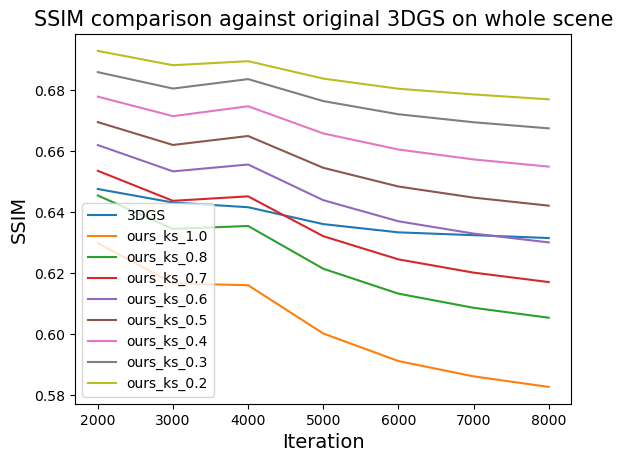

In [23]:
import matplotlib.pyplot as plt
import numpy as np

for scene_dir in scene_dirs:
    label = ""
    if scene_dir == "all":
        label = "3DGS"
    else:
        dir = scene_dir.split("-")
        label = "ours_ks_" + dir[1]
    x = []
    y = []
    for iter in [2000,3000,4000,5000,6000,7000,8000]:
        method = "ours_" + str(iter)
        y.append(full_dict[scene_dir][method]["SSIM"])
        x.append(iter)
    plt.plot(x, y, label=label)
plt.title('SSIM comparison against original 3DGS on whole scene', fontsize=15)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('SSIM', fontsize=14)
plt.legend()
plt.show()

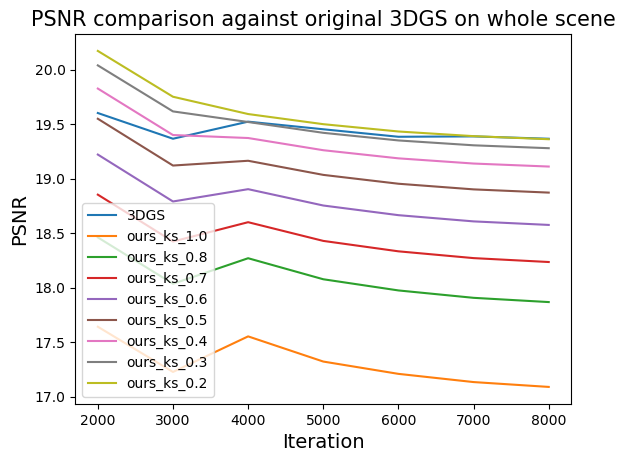

In [24]:
for scene_dir in scene_dirs:
    label = ""
    if scene_dir == "all":
        label = "3DGS"
    else:
        dir = scene_dir.split("-")
        label = "ours_ks_" + dir[1]
    x = []
    y = []
    for iter in [2000,3000,4000,5000,6000,7000,8000]:
        method = "ours_" + str(iter)
        y.append(full_dict[scene_dir][method]["PSNR"])
        x.append(iter)
    plt.plot(x, y, label=label)
plt.title('PSNR comparison against original 3DGS on whole scene', fontsize=15)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('PSNR', fontsize=14)
plt.legend()
plt.show()

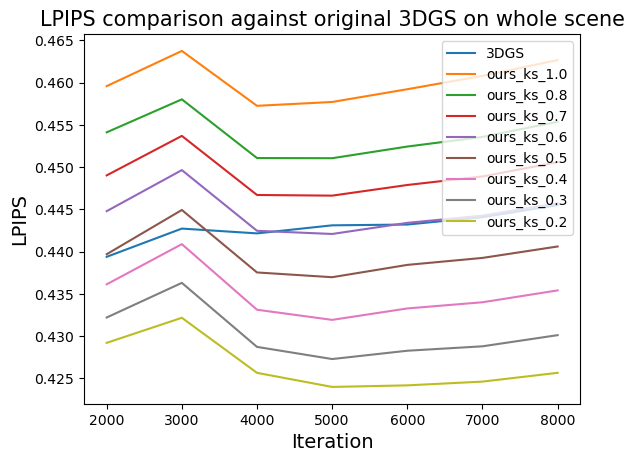

In [25]:
for scene_dir in scene_dirs:
    label = ""
    if scene_dir == "all":
        label = "3DGS"
    else:
        dir = scene_dir.split("-")
        label = "ours_ks_" + dir[1]
    x = []
    y = []
    for iter in [2000,3000,4000,5000,6000,7000,8000]:
        method = "ours_" + str(iter)
        y.append(full_dict[scene_dir][method]["LPIPS"])
        x.append(iter)
    plt.plot(x, y, label=label)
plt.title('LPIPS comparison against original 3DGS on whole scene', fontsize=15)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('LPIPS', fontsize=14)
plt.legend(loc='upper right')
plt.show()

SSIM


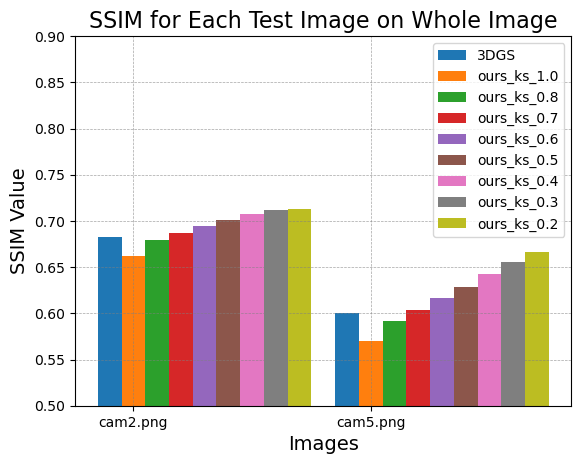

PSNR


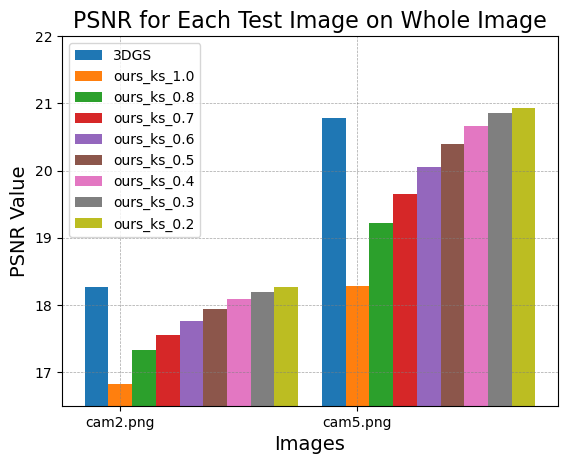

LPIPS


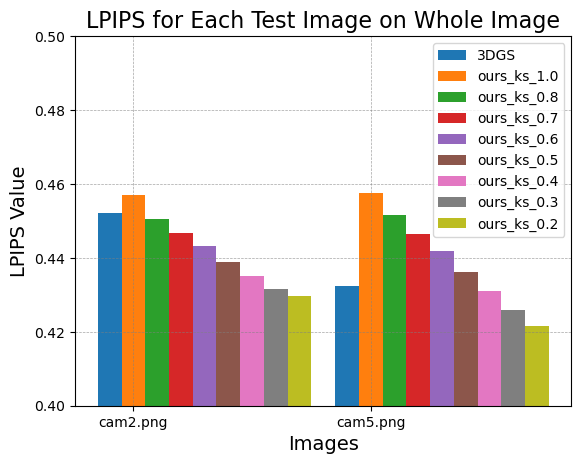

In [40]:
scene_dir = "all"
method = "ours_4000"
fnames = []
show_names = []
for fname in per_view_dict[scene_dir][method]["SSIM"].keys():
    fnames.append(fname)
    if fname == "00000.png":
        show_names.append("cam2.png")
    if fname == "00001.png":
        show_names.append("cam5.png")

metrics = ["SSIM","PSNR","LPIPS"]
ranges = {"SSIM":(0.5, 0.9),"PSNR":(16.5,22.0),"LPIPS":(0.4,0.5)}

for metric in metrics:
    print(metric)

    legends = []
    # ssim_values = []
    # psnr_values = []
    # lpips_values = []
    n_entries = 3  # Number of entries per set
    entry_values = {}

    for scene_dir in scene_dirs:
        legend = ""
        if scene_dir == "all":
            legend = "3DGS"
        else:
            dir = scene_dir.split("-")
            legend = "ours_ks_" + dir[1]
        legends.append(legend)


        # for iter in [2000,3000,4000,5000,6000,7000,8000]:
        values = []
        for fname in fnames:
            values.append(per_view_dict[scene_dir][method][metric][fname])
        
        entry_values.update({legend:values})

    n_sets = len(fnames)
    x = np.arange(n_sets)
    bar_width = 0.1

    for i, set_name in enumerate(legends):
        plt.bar(x + i * bar_width, entry_values[set_name], width=bar_width, label=set_name)


    # Adding title and labels
    title = metric + " for Each Test Image on Whole Image" 
    y_label = metric + " Value"
    plt.title(title, fontsize=16)
    plt.xlabel('Images', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.ylim(ranges[metric])

    # Set the position of the x ticks
    plt.xticks(x + bar_width, show_names)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # Adding a legend
    loc = "upper right"
    if (metric == "PSNR"):
        loc = "upper left"
    plt.legend(loc=loc)

    # Display the plot
    plt.show()



In [41]:
full_dict = {}
per_view_dict = {}
full_dict_polytopeonly = {}
per_view_dict_polytopeonly = {}

crop_dict = {"00000.png":(300,200,1240,1500)}
crop_dict.update({"00001.png":(170,400,700,1650)})
for scene_dir in scene_dirs:
    try:
        # print("Scene:", scene_dir)
        full_dict[scene_dir] = {}
        per_view_dict[scene_dir] = {}
        full_dict_polytopeonly[scene_dir] = {}
        per_view_dict_polytopeonly[scene_dir] = {}

        test_dir = os.path.join(model_path, scene_dir, "test")
        for method in os.listdir(test_dir):
            # print("Method:", method)

            full_dict[scene_dir][method] = {}
            per_view_dict[scene_dir][method] = {}
            full_dict_polytopeonly[scene_dir][method] = {}
            per_view_dict_polytopeonly[scene_dir][method] = {}

            method_dir = os.path.join(test_dir, method)
            gt_dir = os.path.join(method_dir, "gt")
            renders_dir = os.path.join(method_dir, "renders")
            # print("Reading images")
            renders, gts, image_names = readImages(renders_dir, gt_dir,crop_dict)

            ssims = []
            psnrs = []
            lpipss = []

            # print("Calculating metrics")
            for idx in tqdm(range(len(renders)), desc="Metric evaluation progress"):
                # [180:900,300:1650]
                ssims.append(ssim(renders[idx], gts[idx]))
                psnrs.append(psnr(renders[idx], gts[idx]))
                lpipss.append(lpips(renders[idx], gts[idx], net_type='vgg'))

            # print("  SSIM : {:>12.7f}".format(torch.tensor(ssims).mean(), ".5"))
            # print("  PSNR : {:>12.7f}".format(torch.tensor(psnrs).mean(), ".5"))
            # print("  LPIPS: {:>12.7f}".format(torch.tensor(lpipss).mean(), ".5"))
            # print("")

            # print("Saving metrics")
            full_dict[scene_dir][method].update({"SSIM": torch.tensor(ssims).mean().item(),
                                                    "PSNR": torch.tensor(psnrs).mean().item(),
                                                    "LPIPS": torch.tensor(lpipss).mean().item()})
            per_view_dict[scene_dir][method].update({"SSIM": {name: ssim for ssim, name in zip(torch.tensor(ssims).tolist(), image_names)},
                                                        "PSNR": {name: psnr for psnr, name in zip(torch.tensor(psnrs).tolist(), image_names)},
                                                        "LPIPS": {name: lp for lp, name in zip(torch.tensor(lpipss).tolist(), image_names)}})

            # with open(scene_dir + "/results.json", 'w') as fp:
            #     json.dump(full_dict[scene_dir], fp, indent=True)
            # with open(scene_dir + "/per_view.json", 'w') as fp:
            #     json.dump(per_view_dict[scene_dir], fp, indent=True)
    except:
        print("Unable to compute metrics for model", scene_dir)

Metric evaluation progress: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


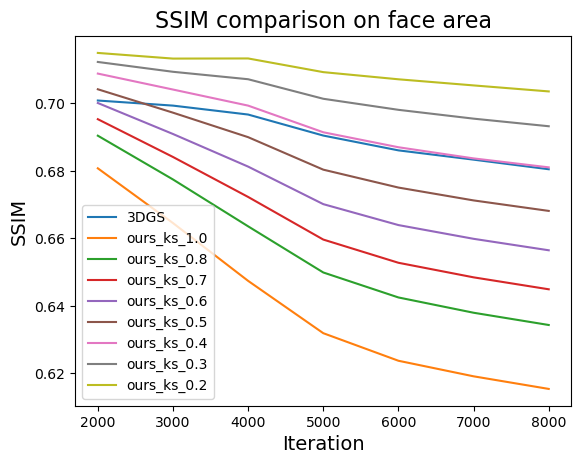

In [42]:
import matplotlib.pyplot as plt
import numpy as np

for scene_dir in scene_dirs:
    label = ""
    if scene_dir == "all":
        label = "3DGS"
    else:
        dir = scene_dir.split("-")
        label = "ours_ks_" + dir[1]
    x = []
    y = []
    for iter in [2000,3000,4000,5000,6000,7000,8000]:
        method = "ours_" + str(iter)
        y.append(full_dict[scene_dir][method]["SSIM"])
        x.append(iter)
    plt.plot(x, y, label=label)
plt.title('SSIM comparison on face area', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('SSIM', fontsize=14)
plt.legend()
plt.show()

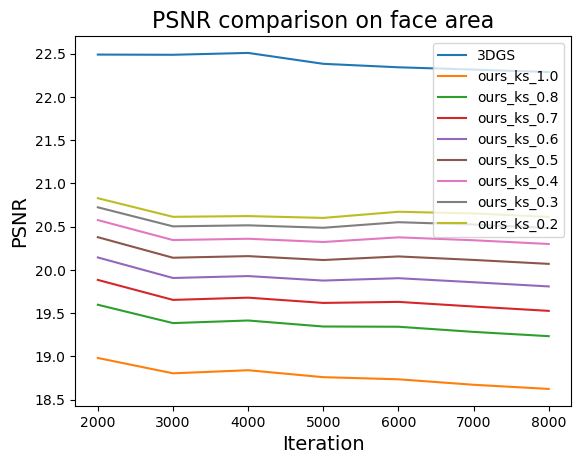

In [34]:
for scene_dir in scene_dirs:
    label = ""
    if scene_dir == "all":
        label = "3DGS"
    else:
        dir = scene_dir.split("-")
        label = "ours_ks_" + dir[1]
    x = []
    y = []
    for iter in [2000,3000,4000,5000,6000,7000,8000]:
        method = "ours_" + str(iter)
        y.append(full_dict[scene_dir][method]["PSNR"])
        x.append(iter)
    plt.plot(x, y, label=label)
plt.title('PSNR comparison on face area', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('PSNR', fontsize=14)
plt.legend(loc='upper right')
plt.show()

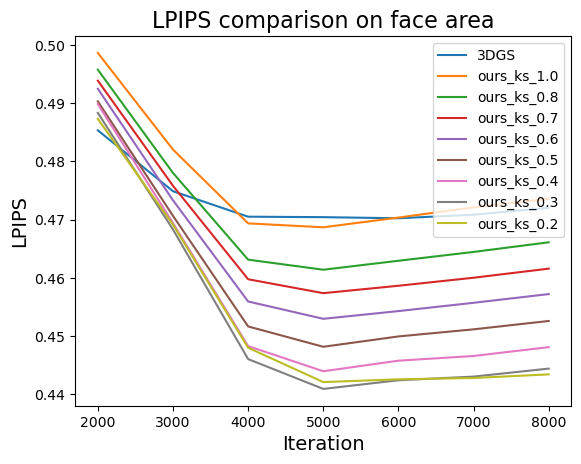

In [35]:
for scene_dir in scene_dirs:
    label = ""
    if scene_dir == "all":
        label = "3DGS"
    else:
        dir = scene_dir.split("-")
        label = "ours_ks_" + dir[1]
    x = []
    y = []
    for iter in [2000,3000,4000,5000,6000,7000,8000]:
        method = "ours_" + str(iter)
        y.append(full_dict[scene_dir][method]["LPIPS"])
        x.append(iter)
    plt.plot(x, y, label=label)
plt.title('LPIPS comparison on face area', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('LPIPS', fontsize=14)
plt.legend(loc='upper right')
plt.show()

SSIM


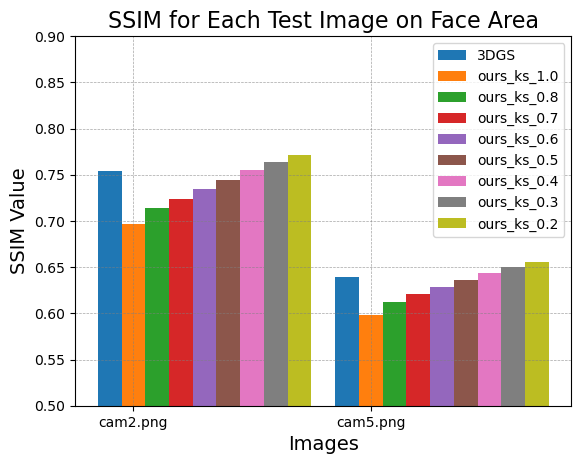

PSNR


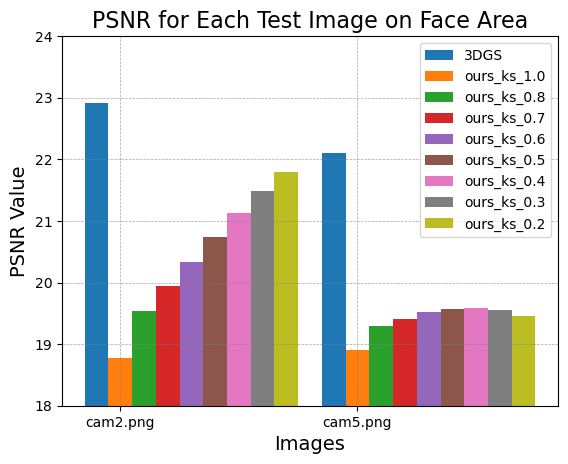

LPIPS


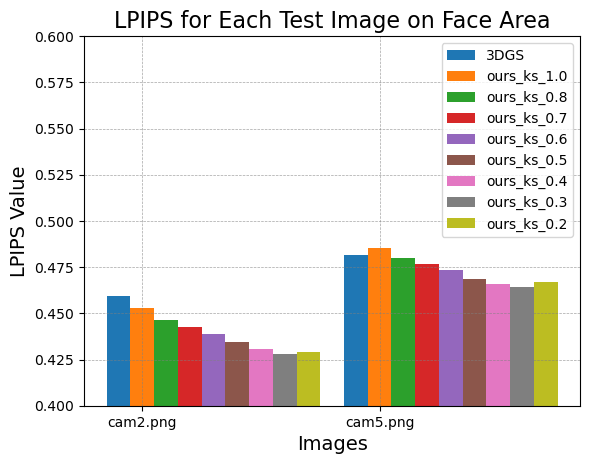

In [43]:
import matplotlib.pyplot as plt
import numpy as np



scene_dir = "all"
method = "ours_4000"
fnames = []
show_names = []
for fname in per_view_dict[scene_dir][method]["SSIM"].keys():
    fnames.append(fname)
    if fname == "00000.png":
        show_names.append("cam2.png")
    if fname == "00001.png":
        show_names.append("cam5.png")
metrics = ["SSIM","PSNR","LPIPS"]
ranges = {"SSIM":(0.5, 0.9),"PSNR":(18.0,24.0),"LPIPS":(0.4,0.6)}

for metric in metrics:
    print(metric)

    legends = []
    # ssim_values = []
    # psnr_values = []
    # lpips_values = []
    n_entries = 3  # Number of entries per set
    entry_values = {}

    for scene_dir in scene_dirs:
        legend = ""
        if scene_dir == "all":
            legend = "3DGS"
        else:
            dir = scene_dir.split("-")
            legend = "ours_ks_" + dir[1]
        legends.append(legend)


        # for iter in [2000,3000,4000,5000,6000,7000,8000]:
        values = []
        for fname in fnames:
            values.append(per_view_dict[scene_dir][method][metric][fname])
        
        entry_values.update({legend:values})

    n_sets = len(fnames)
    x = np.arange(n_sets)
    bar_width = 0.1

    for i, set_name in enumerate(legends):
        plt.bar(x + i * bar_width, entry_values[set_name], width=bar_width, label=set_name)


    # Adding title and labels
    title = metric + " for Each Test Image on Face Area" 
    y_label = metric + " Value"
    plt.title(title, fontsize=16)
    plt.xlabel('Images', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.ylim(ranges[metric])

    # Set the position of the x ticks
    plt.xticks(x + bar_width, show_names)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # Adding a legend
    plt.legend(loc="upper right")

    # Display the plot
    plt.show()

